In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Data/2021-train.csv')

df = df.drop(df[df['pitch_type'].isnull()].index)

This notebook is looking at how players swing percentages change as they get promoted to new levels in their baseball career. Looking at how their swing percentages change is an important metric, as players could be more or less aggressive in their swing choice as they move up to the next level, maybe trying to "prove themselves" right away when they get promoted.

First off, let's get all players who have moved up one or more levels from our dataset and create our "is_swing" variable like we did in the Mariners Challenge notebook.

In [3]:
promo_df = pd.DataFrame()

for player in df['batter_id'].unique():
    if len(df[df['batter_id'] == player]['level'].unique()) > 1:
        promo_df = promo_df.append(df[df['batter_id'] == player])

promo_df['date'] = pd.to_datetime(promo_df['date'], infer_datetime_format=True)

promo_df = promo_df.sort_values(by=['date', 'inning', 'outs'])

is_swing_list = ['InPlay', 'StrikeSwinging', 'FoulBall']
promo_df['is_swing'] = promo_df['pitch_call'].apply(lambda x: 1 if x in is_swing_list else 0)
promo_df.head()

,date,level,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,...,zone_speed,vert_approach_angle,horz_approach_angle,x55,y55,z55,pitch_type,pitch_call,pitch_id,is_swing
55273,2019-04-01,MLB,c3ededfb,Right,7c67a595,Left,d0d69f32,9c6cbb5e,9c6cbb5e,1,...,70.273697,-10.65510,-3.36974,-1.77448,55,6.17982,CU,InPlay,e3f3361a,1
108952,2019-04-01,MLB,c3ededfb,Right,7c67a595,Left,d0d69f32,9c6cbb5e,9c6cbb5e,1,...,77.949799,-6.84386,1.27790,-1.90512,55,6.11197,CH,BallCalled,257bbfd0,0
338587,2019-04-01,MLB,c3ededfb,Right,7c67a595,Left,d0d69f32,9c6cbb5e,9c6cbb5e,1,...,82.922897,-5.94736,-2.62424,-1.95197,55,6.19003,FA,StrikeCalled,05360c03,0
62546,2019-04-01,MLB,68958b87,Left,75bfc8e8,Right,a69810e0,9c6cbb5e,9c6cbb5e,1,...,83.320099,-2.62870,2.46120,1.40550,55,6.82831,FA,BallCalled,0b2b06be,0
119257,2019-04-01,MLB,68958b87,Left,75bfc8e8,Right,a69810e0,9c6cbb5e,9c6cbb5e,1,...,83.285500,-4.89168,1.13687,1.50535,55,6.87517,FA,InPlay,17bed8f8,1


Now that we have all of the players we want to look at, let's first look at their swing percentag as the season goes on by each passing day.

In [4]:
swing_percentage_df = pd.DataFrame(promo_df.groupby(['batter_id', 'date']).count()['is_swing'])
swing_percentage_df = swing_percentage_df.rename({'is_swing': 'number_pitches_seen'}, axis=1)

swing_percentage_df['number_of_swings'] = promo_df.groupby(['batter_id', 'date']).sum()['is_swing'].astype('int')
swing_percentage_df['level'] = promo_df.groupby(['batter_id', 'date']).first()['level']
swing_percentage_df['swing_percentage'] = round((swing_percentage_df['number_of_swings'] / swing_percentage_df['number_pitches_seen']) * 100, 2)
swing_percentage_df.reset_index(inplace=True)
swing_percentage_df

,batter_id,date,number_pitches_seen,number_of_swings,level,swing_percentage
0,002a3a2c,2019-04-04,25,12,AA,48.00
1,002a3a2c,2019-04-05,16,8,AA,50.00
2,002a3a2c,2019-04-06,16,6,AA,37.50
3,002a3a2c,2019-04-08,13,6,AA,46.15
4,002a3a2c,2019-04-09,22,11,AA,50.00
...,...,...,...,...,...,...
18430,ffe7832e,2019-06-26,18,8,MLB,44.44
18431,ffe7832e,2019-06-27,18,8,MLB,44.44
18432,ffe7832e,2019-06-28,17,7,MLB,41.18
18433,ffe7832e,2019-06-29,18,8,MLB,44.44


Now we can make a boxplot of the swing_percentage distributions to gather some information on how they change with each level of baseball.

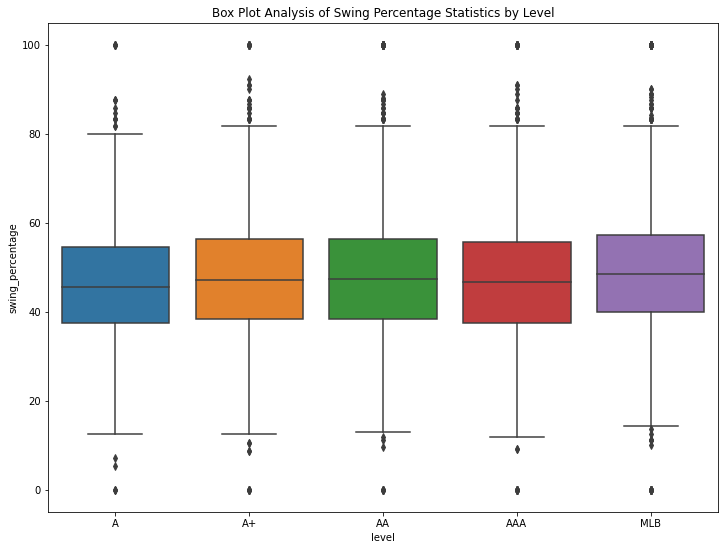

In [5]:
plt.figure(figsize=(12,9))
g = sns.boxplot(x=swing_percentage_df['level'], y=swing_percentage_df['swing_percentage'], order=['A', 'A+', 'AA', 'AAA', 'MLB'])
plt.title('Box Plot Analysis of Swing Percentage Statistics by Level')
plt.savefig('Charts/box_plot_analysis.png')

So we can see here that the average swing percentages rise slightly until AAA where they drop back down again, but then go back up when players hit the MLB. Very interesting, maybe in AAA hitters are more selective of their pitches and want to make sure they're hitting pitches they know they can get into play more-so than at every other level.

Next we'll take a look at swing percentage broken down by pitch type and by level of baseball.

In [6]:
pitch_percentage_df = pd.DataFrame(promo_df.groupby(['level', 'pitch_type']).count()['is_swing'])
pitch_percentage_df = pitch_percentage_df.rename({'is_swing': 'number_pitches_seen'}, axis=1)

pitch_percentage_df['number_of_swings'] = promo_df.groupby(['level', 'pitch_type']).sum()['is_swing'].astype('int')
pitch_percentage_df['swing_percentage'] = round((pitch_percentage_df['number_of_swings'] / pitch_percentage_df['number_pitches_seen']) * 100, 2)
pitch_percentage_df.reset_index(inplace=True)
pitch_percentage_df

,level,pitch_type,number_pitches_seen,number_of_swings,swing_percentage
0,A,CH,4454,2176,48.85
1,A,CU,2834,960,33.87
2,A,FA,17959,8369,46.60
3,A,KN,15,7,46.67
4,A,SI,1246,557,44.70
5,A,SL,5658,2466,43.58
6,A+,CH,7337,3598,49.04
7,A+,CU,5039,1892,37.55
8,A+,FA,29525,13922,47.15
9,A+,KN,17,5,29.41


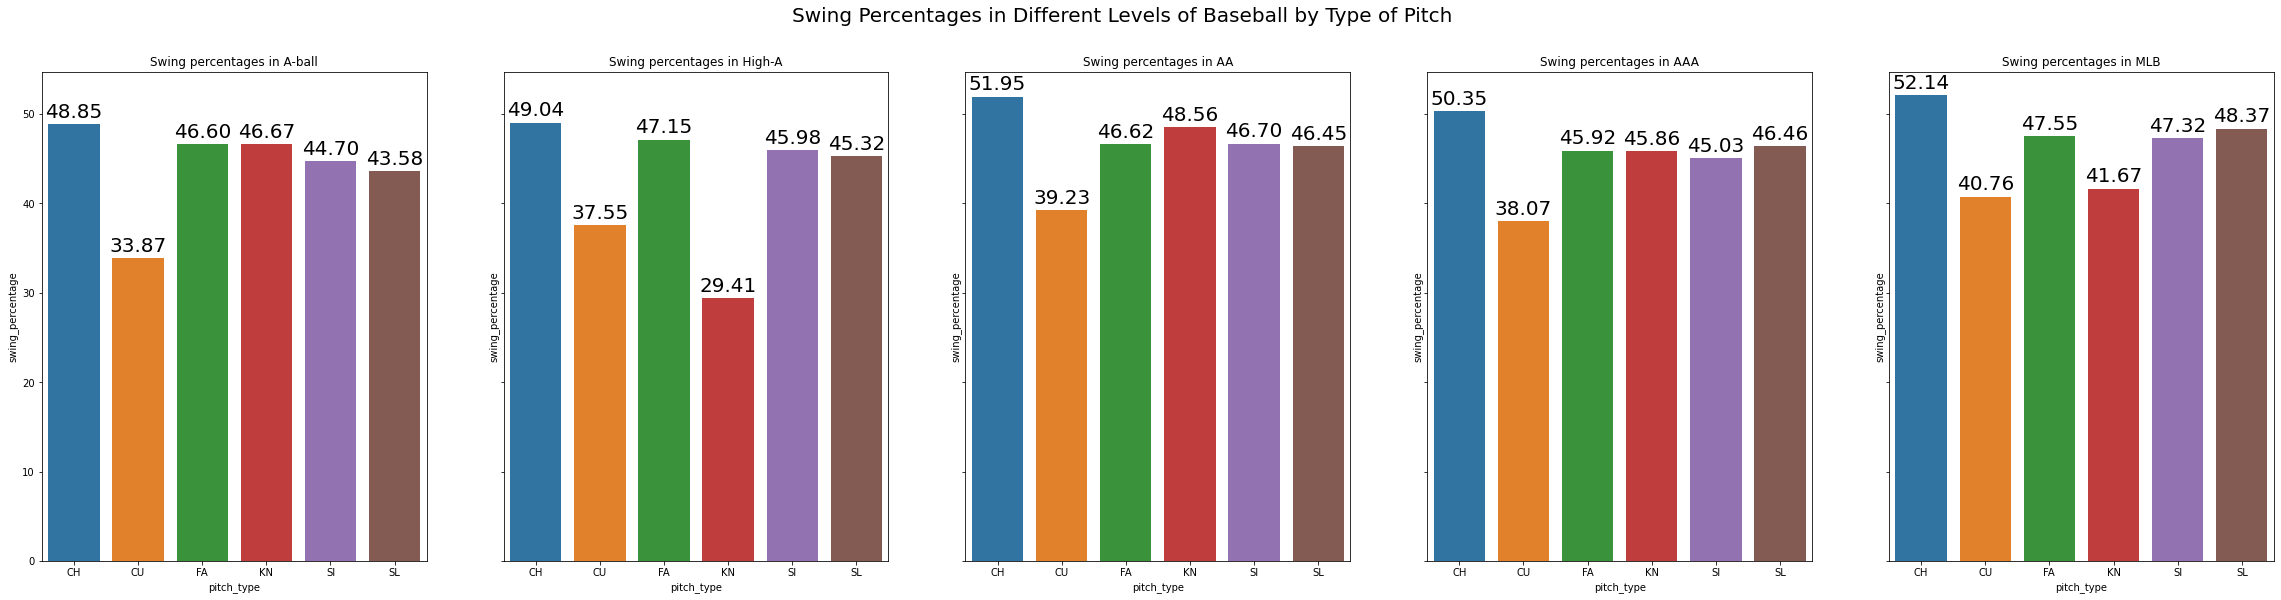

In [7]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(40,9), sharey='all')
fig.suptitle('Swing Percentages in Different Levels of Baseball by Type of Pitch', fontsize=20)
g1 = sns.barplot(x='pitch_type', y='swing_percentage', data=pitch_percentage_df[pitch_percentage_df['level'] == 'A'], ci=False, ax=ax1)
ax1.set_title('Swing percentages in A-ball')
for p in g1.patches:
    g1.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    
g2 = sns.barplot(x='pitch_type', y='swing_percentage', data=pitch_percentage_df[pitch_percentage_df['level'] == 'A+'], ci=False, ax=ax2)
ax2.set_title('Swing percentages in High-A')
for p in g2.patches:
    g2.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    
g3 = sns.barplot(x='pitch_type', y='swing_percentage', data=pitch_percentage_df[pitch_percentage_df['level'] == 'AA'], ci=False, ax=ax3)
ax3.set_title('Swing percentages in AA')
for p in g3.patches:
    g3.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    
g4 = sns.barplot(x='pitch_type', y='swing_percentage', data=pitch_percentage_df[pitch_percentage_df['level'] == 'AAA'], ci=False, ax=ax4)
ax4.set_title('Swing percentages in AAA')
for p in g4.patches:
    g4.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   size=20,
                   xytext=(0, 12), 
                   textcoords='offset points')
    
g5 = sns.barplot(x='pitch_type', y='swing_percentage', data=pitch_percentage_df[pitch_percentage_df['level'] == 'MLB'], ci=False, ax=ax5)
ax5.set_title('Swing percentages in MLB')
for p in g5.patches:
    g5.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   size=20,
                   xytext=(0, 12), 
                   textcoords='offset points')

plt.savefig('Charts/Swing_percentage_by_level_and_type_of_pitch.png')

This right here doesn't tell us a whole lot, but we can start to see some trends. Let's look at the percent change in these values to draw some conclusions on how much differently hitters at each level swing at pitches.

In [8]:
perc_ch_df = pd.DataFrame(pitch_percentage_df['level'].unique())

for v in pitch_percentage_df['pitch_type'].unique():
    perc_ch_s = pitch_percentage_df[pitch_percentage_df['pitch_type'] == v]
    s = perc_ch_s['swing_percentage']
    perc_ch = round(s.pct_change().reset_index().drop('index', axis=1) * 100, 2)
    perc_ch_df[v] = perc_ch

perc_ch_df = perc_ch_df.rename({0: 'level'}, axis=1)
perc_ch_df.set_index('level', inplace=True)
perc_ch_df.drop('KN', axis=1, inplace=True)
perc_ch_df = perc_ch_df.T
perc_ch_df['A'] = [0, 0, 0, 0, 0]

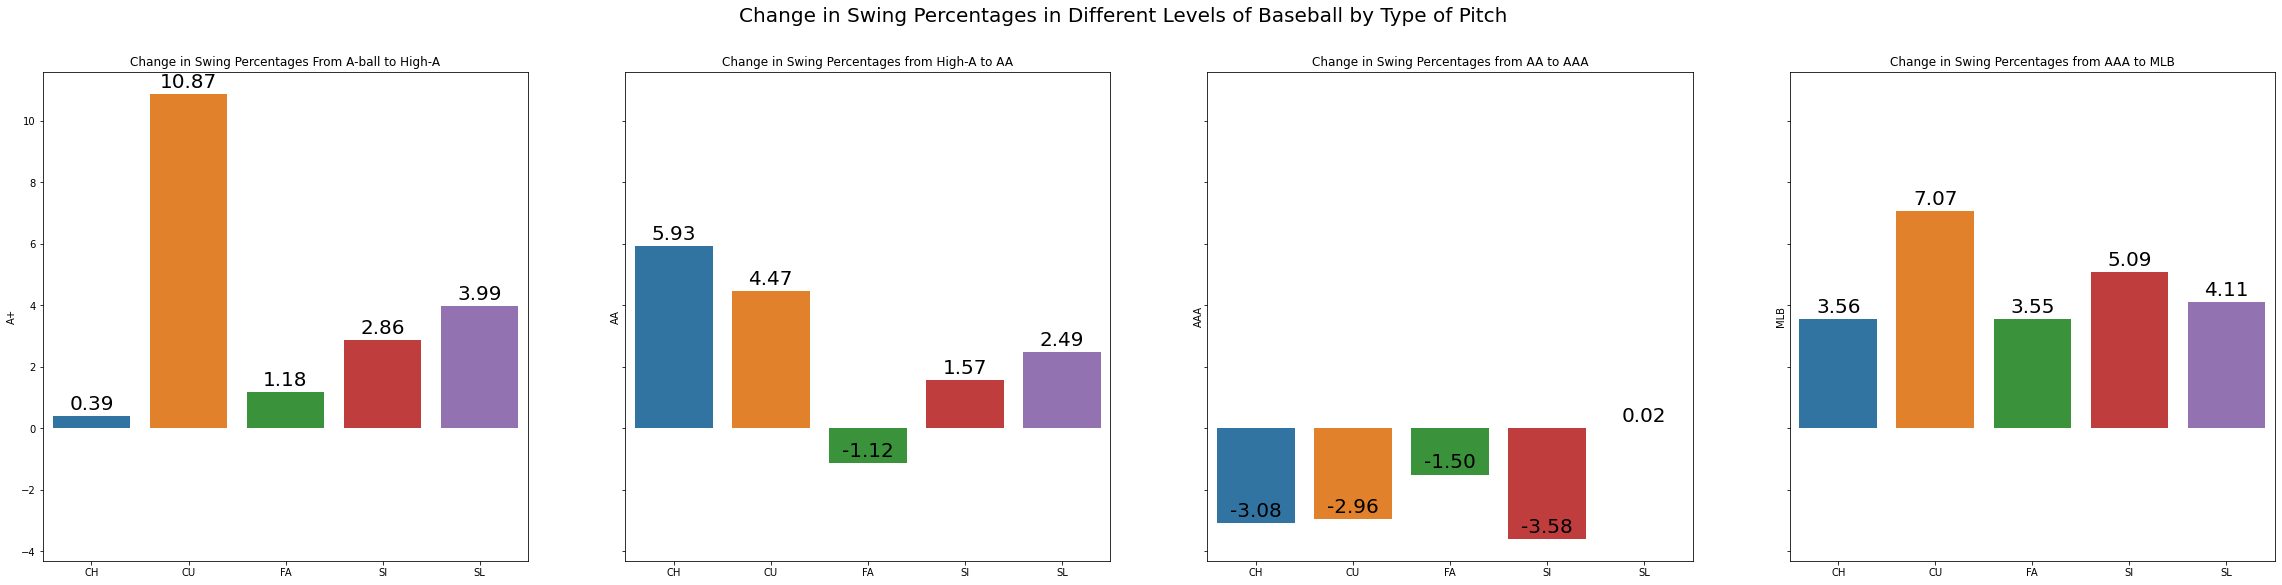

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,9), sharey='all')
fig.suptitle('Change in Swing Percentages in Different Levels of Baseball by Type of Pitch', fontsize=20)
g1 = sns.barplot(x=perc_ch_df.index, y='A+', data=perc_ch_df, ci=False, ax=ax1)
ax1.set_title('Change in Swing Percentages From A-ball to High-A')
for p in g1.patches:
    g1.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 12), 
                   textcoords = 'offset points')

g2 = sns.barplot(x=perc_ch_df.index, y='AA', data=perc_ch_df, ci=False, ax=ax2)
ax2.set_title('Change in Swing Percentages from High-A to AA')
for p in g2.patches:
    g2.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    
g3 = sns.barplot(x=perc_ch_df.index, y='AAA', data=perc_ch_df, ci=False, ax=ax3)
ax3.set_title('Change in Swing Percentages from AA to AAA')
for p in g3.patches:
    g3.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    
g4 = sns.barplot(x=perc_ch_df.index, y='MLB', data=perc_ch_df, ci=False, ax=ax4)
ax4.set_title('Change in Swing Percentages from AAA to MLB')
for p in g4.patches:
    g4.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 12), 
                   textcoords = 'offset points')

plt.savefig('Charts/change_in_swing_percentage_by_level.png')

Here we have change in swing percentages at each level of baseball, broken down by pitch type. It's very interesting to see that, aside from AAA, players are more likely overall to swing at pitches no matter the pitch type. Especially curveballs. Aside from AAA, the swing percentages of players that are swinging at curveballs are consistently going up, most notably from A-ball to High-A and from AAA to the MLB.

Overall though, it's very interesting that every graph we've looked at up until this point, AAA has always had swing percentages dipping. Perhaps players are being more selective of the pitches they're swinging at, and want to only swing at balls that they know they can put in play. They're only one level away from the MLB, so perhaps players are trying to put on a good show for the organization and selectively swinging at balls they otherwise would have swung at in A, High-A and AA.

Next, we'll take a look at 4 different players, one moving up to each new level, and how their swing percentages have changed over time.

In [10]:
# promo_df[(promo_df['level'] == 'A') | (promo_df['level'] == 'A+')]['batter_id'].unique()
# promo_df[(promo_df['level'] == 'A+') | (promo_df['level'] == 'AA')]['batter_id'].unique()
# promo_df[(promo_df['level'] == 'AA') | (promo_df['level'] == 'AAA')]['batter_id'].unique()
# promo_df[(promo_df['level'] == 'AAA') | (promo_df['level'] == 'MLB')]['batter_id'].unique()

A to High-A: 02a5cee0

High-A to AA: 4499b2da

AA to AAA: ffc05a5e

AAA to MLB: ffc7bd1f

These are the four players we've chosen. They have a good amount of data in their previous league, and have all played at least 10 games in their new league. We're going to get their average swing percentage for the level they have previously played in, then compare that to the first 10 games in their new level and see if any immediate trends pop up.

In [11]:
a_to_ha = promo_df[promo_df['batter_id'] == '02a5cee0']

a_to_ha_df = pd.DataFrame(a_to_ha.groupby(['date', 'level']).count()['is_swing'])
a_to_ha_df = a_to_ha_df.rename({'is_swing': 'number_pitches_seen'}, axis=1)

a_to_ha_df['number_of_swings'] = a_to_ha.groupby(['date', 'level']).sum()['is_swing'].astype('int')
a_to_ha_df['swing_percentage'] = round((a_to_ha_df['number_of_swings'] / a_to_ha_df['number_pitches_seen']) * 100, 2)
a_to_ha_df.reset_index(inplace=True)

mean_swing_perc = a_to_ha_df[a_to_ha_df['level'] == 'A']['swing_percentage'].mean()

first_ten_ha = a_to_ha_df[a_to_ha_df['level'] == 'A+'].head(10)

In [12]:
ha_to_aa = promo_df[promo_df['batter_id'] == '4499b2da']

ha_to_aa_df = pd.DataFrame(ha_to_aa.groupby(['date', 'level']).count()['is_swing'])
ha_to_aa_df = ha_to_aa_df.rename({'is_swing': 'number_pitches_seen'}, axis=1)

ha_to_aa_df['number_of_swings'] = ha_to_aa.groupby(['date', 'level']).sum()['is_swing'].astype('int')
ha_to_aa_df['swing_percentage'] = round((ha_to_aa_df['number_of_swings'] / ha_to_aa_df['number_pitches_seen']) * 100, 2)
ha_to_aa_df.reset_index(inplace=True)

mean_swing_perc = ha_to_aa_df[ha_to_aa_df['level'] == 'A+']['swing_percentage'].mean()

first_ten_aa = ha_to_aa_df[ha_to_aa_df['level'] == 'AA'].head(10)

In [13]:
aa_to_aaa = promo_df[promo_df['batter_id'] == 'ffc05a5e']

aa_to_aaa_df = pd.DataFrame(aa_to_aaa.groupby(['date', 'level']).count()['is_swing'])
aa_to_aaa_df = aa_to_aaa_df.rename({'is_swing': 'number_pitches_seen'}, axis=1)

aa_to_aaa_df['number_of_swings'] = aa_to_aaa.groupby(['date', 'level']).sum()['is_swing'].astype('int')
aa_to_aaa_df['swing_percentage'] = round((aa_to_aaa_df['number_of_swings'] / aa_to_aaa_df['number_pitches_seen']) * 100, 2)
aa_to_aaa_df.reset_index(inplace=True)

mean_swing_perc = aa_to_aaa_df[aa_to_aaa_df['level'] == 'AA']['swing_percentage'].mean()

first_ten_aaa = aa_to_aaa_df[aa_to_aaa_df['level'] == 'AAA'].head(10)

In [14]:
aaa_to_mlb = promo_df[promo_df['batter_id'] == 'ffc7bd1f']

aaa_to_mlb_df = pd.DataFrame(aaa_to_mlb.groupby(['date', 'level']).count()['is_swing'])
aaa_to_mlb_df = aaa_to_mlb_df.rename({'is_swing': 'number_pitches_seen'}, axis=1)

aaa_to_mlb_df['number_of_swings'] = aaa_to_mlb.groupby(['date', 'level']).sum()['is_swing'].astype('int')
aaa_to_mlb_df['swing_percentage'] = round((aaa_to_mlb_df['number_of_swings'] / aaa_to_mlb_df['number_pitches_seen']) * 100, 2)
aaa_to_mlb_df.reset_index(inplace=True)

mean_swing_perc = aaa_to_mlb_df[aaa_to_mlb_df['level'] == 'AAA']['swing_percentage'].mean()

first_ten_mlb = aaa_to_mlb_df[aaa_to_mlb_df['level'] == 'MLB'].head(10)

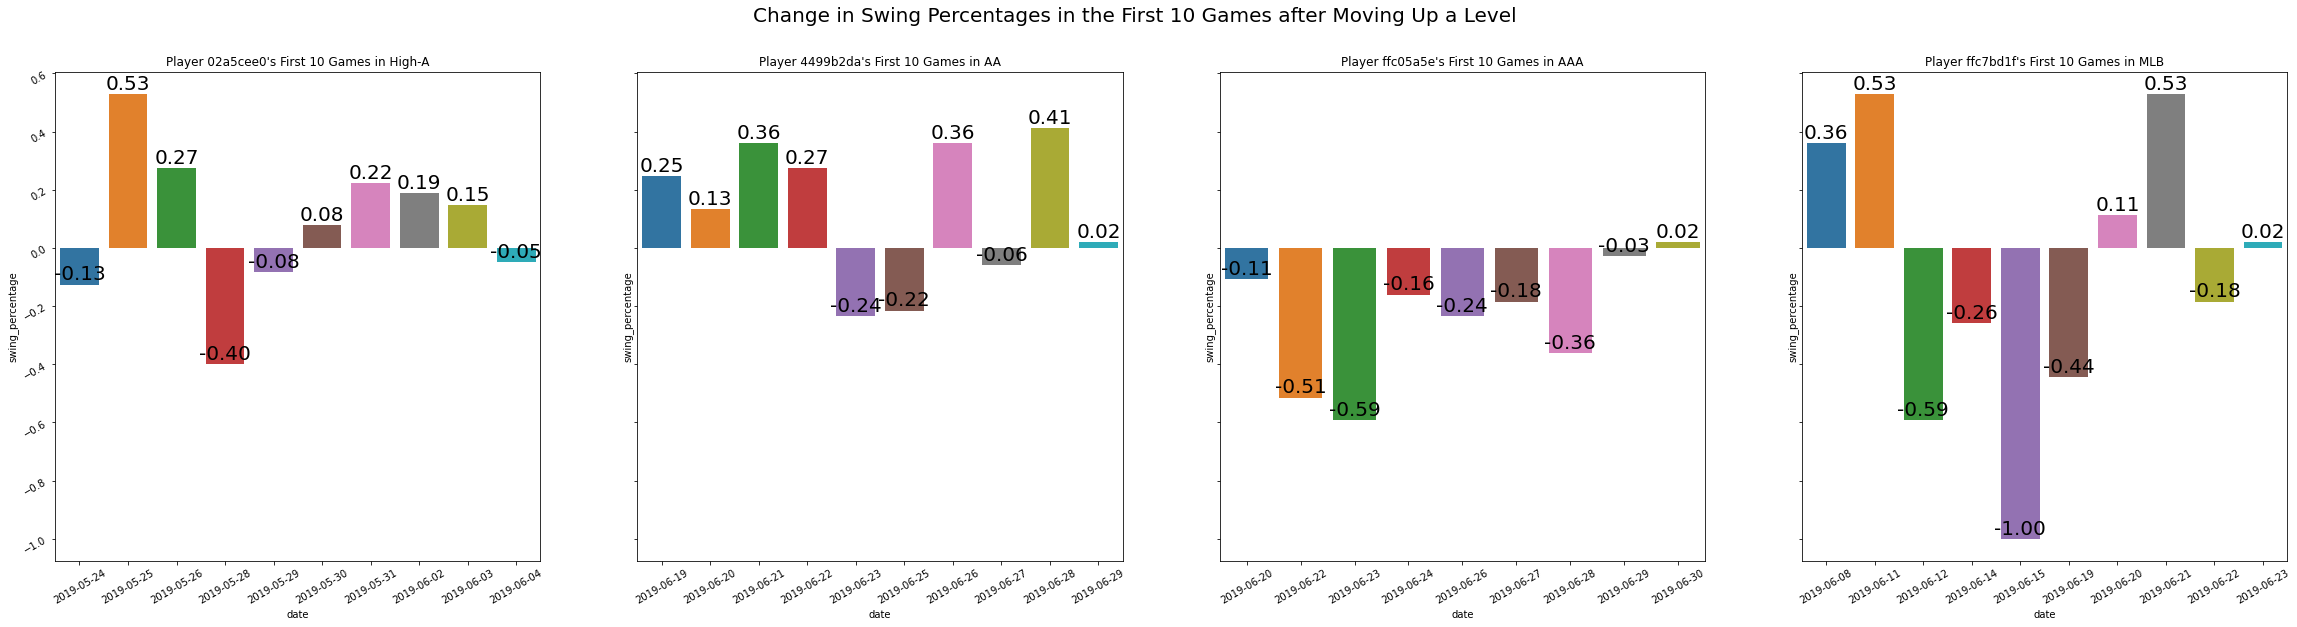

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,9), sharey='all')
fig.suptitle('Change in Swing Percentages in the First 10 Games after Moving Up a Level', fontsize=20)
g1 = sns.barplot(x=first_ten_ha['date'].astype('str'), y=(a_to_ha_df['swing_percentage'] - mean_swing_perc) / mean_swing_perc, data=first_ten_ha, ci=False, ax=ax1)
ax1.tick_params(labelrotation=30)
ax1.set_title('Player 02a5cee0\'s First 10 Games in High-A')
for p in g1.patches:
    g1.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 10), 
                   textcoords = 'offset points')
    
g2 = sns.barplot(x=first_ten_aa['date'].astype('str'), y=(ha_to_aa_df['swing_percentage'] - mean_swing_perc) / mean_swing_perc, data=first_ten_aa, ci=False, ax=ax2)
ax2.tick_params(labelrotation=30)
ax2.set_title('Player 4499b2da\'s First 10 Games in AA')
for p in g2.patches:
    g2.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 10), 
                   textcoords = 'offset points')
    
g3 = sns.barplot(x=first_ten_aaa['date'].astype('str'), y=(aa_to_aaa_df['swing_percentage'] - mean_swing_perc) / mean_swing_perc, data=first_ten_aaa, ci=False, ax=ax3)
ax3.tick_params(labelrotation=30)
ax3.set_title('Player ffc05a5e\'s First 10 Games in AAA')
for p in g3.patches:
    g3.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, 10), 
                   textcoords = 'offset points')
    
g4 = sns.barplot(x=first_ten_mlb['date'].astype('str'), y=(aaa_to_mlb_df['swing_percentage'] - mean_swing_perc) / mean_swing_perc, data=first_ten_mlb, ci=False, ax=ax4)
ax4.tick_params(labelrotation=30)
ax4.set_title('Player ffc7bd1f\'s First 10 Games in MLB')
for p in g4.patches:
    g4.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   size=20,
                   xytext=(0, 10), 
                   textcoords='offset points')
plt.savefig('Charts/first_10_games.png')
plt.show()

These graphs show us how a player's first 10 games at a new level has varied from their average swing percentage at their previous level. A fairly similar trend we've seen previously. High-A and AA have overall increased their swing percentages in the first 10 games they've been at the new level, while AAA has decreased their swing percentages in their first 10 games. For the MLB player, their change in swing percentage has mostly broken away from the trends we've been seeing, as it seems like he's been less likely to swing at pitches in his first 10 games in the bigs. Their could be a variety of reasons for these trends, and these are only four players chosen out of the hundreds in the data set. But this could be repeated for any other player in the data set, and overall we would probably see similar graphs for whichever player we decided to look at.